## 80. id番号への変更

In [1]:
import pandas as pd

DATA_PATH = "./data/news_aggregator_dataset/"

train_df = pd.read_csv(DATA_PATH + "train.txt", delimiter="\t")
valid_df = pd.read_csv(DATA_PATH + "valid.txt", delimiter="\t")
test_df = pd.read_csv(DATA_PATH + "test.txt", delimiter="\t")

print('【学習データ】')
print(train_df['CATEGORY'].value_counts())
print('【検証データ】')
print(valid_df['CATEGORY'].value_counts())
print('【評価データ】')
print(test_df['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [2]:
from collections import defaultdict
import string


d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train_df['TITLE']:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

word2id_dict = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id_dict.values()))}\n')
print('頻度上位20語')
for key in list(word2id_dict)[:20]:
    print(f'{key}: {word2id_dict[key]}')

ID数: 9393

頻度上位20語
to: 1
s: 2
in: 3
UPDATE: 4
on: 5
as: 6
US: 7
for: 8
of: 9
The: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
at: 18
a: 19
A: 20


In [3]:
def tokenizer(text, word2id=word2id_dict, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [4]:
text = train_df.iloc[1, train_df.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Andrew Garfield wants Black-HispanicSpiderman
ID列: [504, 520, 638, 541, 0]


## 81. RNNによる予測

In [5]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, device):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

/home/morioka/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [7]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test_df['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = MyDataset(train_df['TITLE'], y_train, tokenizer)
dataset_valid = MyDataset(valid_df['TITLE'], y_valid, tokenizer)
dataset_test = MyDataset(test_df['TITLE'], y_test, tokenizer)

print(f'datasetの長さ: {len(dataset_train)}')
print('dataset[index]:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

datasetの長さ: 10684
dataset[index]:
  inputs: tensor([504, 520, 638, 541,   0])
  labels: 2


In [8]:

VOCAB_SIZE = len(set(word2id_dict.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 学習せずsoftmaxのみで出力
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2526, 0.1059, 0.2868, 0.3547]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1617, 0.1372, 0.2318, 0.4692]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2599, 0.2670, 0.3197, 0.1534]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1622, 0.5067, 0.1863, 0.1448]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3870, 0.1696, 0.2195, 0.2239]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2029, 0.3864, 0.2016, 0.2091]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1816, 0.4235, 0.2585, 0.1364]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2426, 0.2194, 0.1564, 0.3816]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2342, 0.1803, 0.2854, 0.3001]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2313, 0.1110, 0.2329, 0.4248]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習

In [9]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)

            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(dataset), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()

        loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'./data/checkpoints/checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()

In [11]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.0974, accuracy_train: 0.5395, loss_valid: 1.1179, accuracy_valid: 0.5090, 309.6095sec
epoch: 2, loss_train: 1.0038, accuracy_train: 0.6009, loss_valid: 1.0591, accuracy_valid: 0.5606, 306.0615sec
epoch: 3, loss_train: 0.8601, accuracy_train: 0.6806, loss_valid: 0.9298, accuracy_valid: 0.6602, 305.0134sec
epoch: 4, loss_train: 0.7211, accuracy_train: 0.7446, loss_valid: 0.8091, accuracy_valid: 0.7178, 302.6516sec
epoch: 5, loss_train: 0.6217, accuracy_train: 0.7762, loss_valid: 0.7380, accuracy_valid: 0.7433, 302.8692sec
epoch: 6, loss_train: 0.5551, accuracy_train: 0.7988, loss_valid: 0.7043, accuracy_valid: 0.7597, 303.8045sec
epoch: 7, loss_train: 0.4979, accuracy_train: 0.8166, loss_valid: 0.6799, accuracy_valid: 0.7650, 302.5950sec
epoch: 8, loss_train: 0.4690, accuracy_train: 0.8283, loss_valid: 0.6786, accuracy_valid: 0.7552, 305.6070sec
epoch: 9, loss_train: 0.4539, accuracy_train: 0.8336, loss_valid: 0.6811, accuracy_valid: 0.7530, 300.9334sec
epoch: 10,

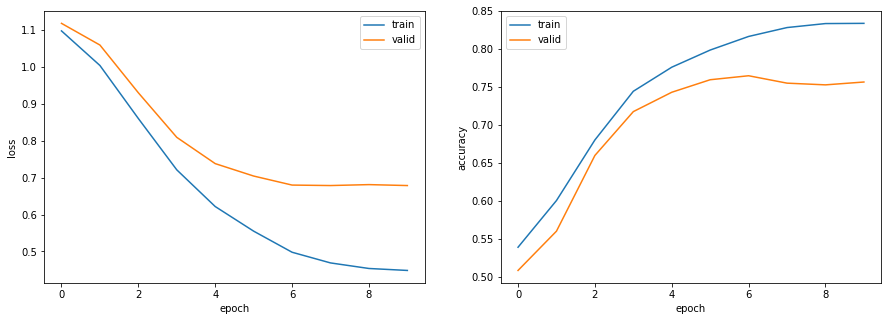

accuracy (train): 0.834
accuracy (valid): 0.753


In [12]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 84. 単語ベクトルの導入

In [13]:
from gensim.models import KeyedVectors

keyed_vec = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id_dict.keys()):
  if word in keyed_vec:
    weights[i] = keyed_vec[word]
    words_in_pretrained += 1
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9164 / 9394
torch.Size([9394, 300])


In [61]:
class RNN_mod1(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
        return hidden

In [15]:
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [16]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1740, accuracy_train: 0.4056, loss_valid: 1.1744, accuracy_valid: 0.4094, 108.7253sec
epoch: 2, loss_train: 1.1803, accuracy_train: 0.4236, loss_valid: 1.1783, accuracy_valid: 0.4431, 108.3137sec
epoch: 3, loss_train: 1.1622, accuracy_train: 0.4995, loss_valid: 1.1487, accuracy_valid: 0.5180, 107.7700sec
epoch: 4, loss_train: 1.0829, accuracy_train: 0.5990, loss_valid: 1.0721, accuracy_valid: 0.6018, 107.9873sec
epoch: 5, loss_train: 1.0093, accuracy_train: 0.6274, loss_valid: 1.0031, accuracy_valid: 0.6295, 107.1010sec
epoch: 6, loss_train: 0.9949, accuracy_train: 0.6384, loss_valid: 0.9992, accuracy_valid: 0.6362, 108.3231sec
epoch: 7, loss_train: 0.9972, accuracy_train: 0.6334, loss_valid: 1.0003, accuracy_valid: 0.6287, 108.3649sec
epoch: 8, loss_train: 0.9459, accuracy_train: 0.6583, loss_valid: 0.9615, accuracy_valid: 0.6475, 105.9707sec
epoch: 9, loss_train: 0.9502, accuracy_train: 0.6565, loss_valid: 0.9676, accuracy_valid: 0.6512, 107.3998sec
epoch: 10,

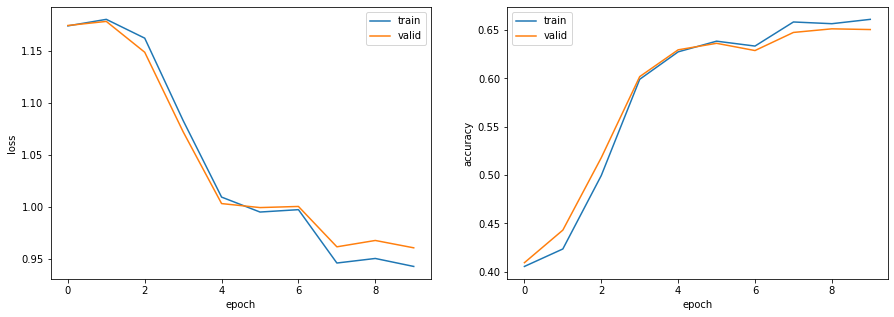

accuracy (train): 0.661
accuracy (valid): 0.651


In [17]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 85. 双方向RNN・多層化

In [18]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2 #2層
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True) #bidirectional:双方向でモデル作成

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1766, accuracy_train: 0.4076, loss_valid: 1.1783, accuracy_valid: 0.4072, 112.3449sec
epoch: 2, loss_train: 1.2154, accuracy_train: 0.4020, loss_valid: 1.2134, accuracy_valid: 0.4042, 112.9568sec
epoch: 3, loss_train: 1.2444, accuracy_train: 0.3966, loss_valid: 1.2413, accuracy_valid: 0.3975, 112.6263sec
epoch: 4, loss_train: 1.0429, accuracy_train: 0.6031, loss_valid: 1.0392, accuracy_valid: 0.6085, 113.6457sec
epoch: 5, loss_train: 1.0505, accuracy_train: 0.5885, loss_valid: 1.0460, accuracy_valid: 0.5838, 112.8040sec
epoch: 6, loss_train: 1.0776, accuracy_train: 0.5728, loss_valid: 1.0735, accuracy_valid: 0.5786, 113.2502sec
epoch: 7, loss_train: 0.9903, accuracy_train: 0.6267, loss_valid: 0.9994, accuracy_valid: 0.6198, 113.0350sec
epoch: 8, loss_train: 0.9643, accuracy_train: 0.6399, loss_valid: 0.9763, accuracy_valid: 0.6370, 113.4529sec
epoch: 9, loss_train: 0.9896, accuracy_train: 0.6261, loss_valid: 1.0011, accuracy_valid: 0.6190, 112.6520sec
epoch: 10,

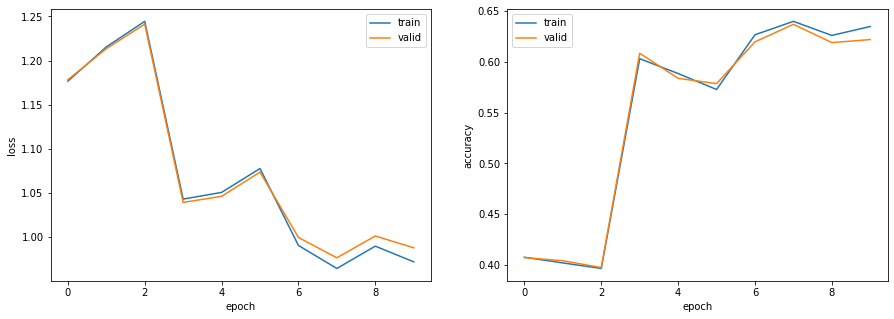

accuracy (train): 0.635
accuracy (valid): 0.629


In [19]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 86. 畳み込みニューラルネットワーク(CNN)
定義のみ

In [20]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)
    
    def forward(self, x):
        # x.size() = (batch_size, seq_len)
        emb = self.emb(x).unsqueeze(1)
        # emb.size() = (batch_size, 1, seq_len, emb_size)
        conv = self.conv(emb)
        # conv.size() = (batch_size, out_channels, seq_len, 1)
        act = F.relu(conv.squeeze(3))
        # act.size() = (batch_size, out_channels, seq_len)
        max_pool = F.max_pool1d(act, act.size()[2])
        # max_pool.size() = (batch_size, out_channels, 1)
        out = self.fc(self.drop(max_pool.squeeze(2)))
        # out.size() = (batch_size, output_size)
        return out

In [21]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2699, 0.2784, 0.2314, 0.2203]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2638, 0.2535, 0.2381, 0.2446]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2792, 0.2717, 0.2533, 0.1959]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2577, 0.2769, 0.2299, 0.2355]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2722, 0.2512, 0.2412, 0.2354]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2725, 0.2515, 0.2308, 0.2451]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2639, 0.2776, 0.2317, 0.2268]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2788, 0.2554, 0.2399, 0.2259]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2840, 0.2700, 0.2109, 0.2351]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2678, 0.2673, 0.2333, 0.2316]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習

In [22]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1307, accuracy_train: 0.4675, loss_valid: 1.1340, accuracy_valid: 0.4633, 104.0288sec
epoch: 2, loss_train: 1.0680, accuracy_train: 0.6440, loss_valid: 1.0792, accuracy_valid: 0.6355, 104.2551sec
epoch: 3, loss_train: 0.9830, accuracy_train: 0.6786, loss_valid: 1.0067, accuracy_valid: 0.6602, 104.2562sec
epoch: 4, loss_train: 0.9076, accuracy_train: 0.7029, loss_valid: 0.9435, accuracy_valid: 0.6751, 104.8896sec
epoch: 5, loss_train: 0.8537, accuracy_train: 0.7168, loss_valid: 0.8992, accuracy_valid: 0.6939, 103.9433sec
epoch: 6, loss_train: 0.8158, accuracy_train: 0.7285, loss_valid: 0.8698, accuracy_valid: 0.7036, 104.6210sec
epoch: 7, loss_train: 0.7915, accuracy_train: 0.7353, loss_valid: 0.8509, accuracy_valid: 0.7081, 104.0043sec
epoch: 8, loss_train: 0.7776, accuracy_train: 0.7389, loss_valid: 0.8409, accuracy_valid: 0.7133, 105.2780sec
epoch: 9, loss_train: 0.7712, accuracy_train: 0.7415, loss_valid: 0.8359, accuracy_valid: 0.7133, 104.0693sec
epoch: 10,

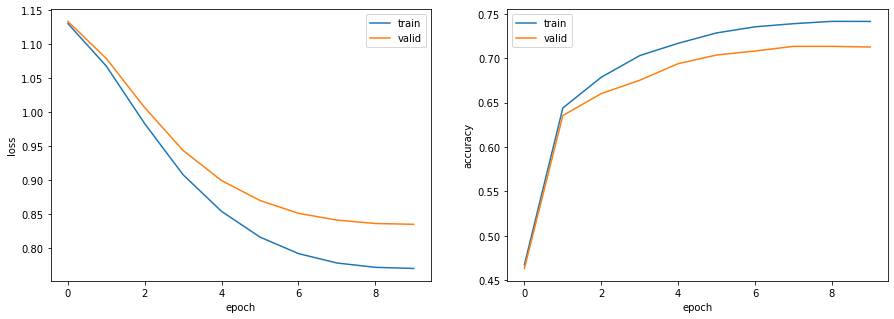

accuracy (train): 0.741
accuracy (valid): 0.698


In [23]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 88. パラメータチューニング

In [66]:
import optuna

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
    momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))
    hidden_size = int(trial.suggest_discrete_uniform('hidden_size', 50, 200, 50))
    num_layers = int(trial.suggest_discrete_uniform('num_layers', 2, 4, 1))

    VOCAB_SIZE = len(set(word2id_dict.values())) + 1
    PADDING_IDX = len(set(word2id_dict.values()))
    OUTPUT_SIZE = 4
    NUM_EPOCHS = 10
    EMB_SIZE = 300

    model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, hidden_size, num_layers, emb_weights=weights, bidirectional=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

    loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion) 

    return loss_valid

In [68]:
# 最適化
study = optuna.create_study()
study.optimize(objective, timeout=7200)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-06-27 23:44:00,282] A new study created in memory with name: no-name-b468be28-a346-4b67-9f7c-909364edb866
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/home/morioka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :fu

epoch: 1, loss_train: 1.1653, accuracy_train: 0.4149, loss_valid: 1.1657, accuracy_valid: 0.4079, 115.8254sec
epoch: 2, loss_train: 1.1632, accuracy_train: 0.4173, loss_valid: 1.1639, accuracy_valid: 0.4094, 117.2368sec
epoch: 3, loss_train: 1.1694, accuracy_train: 0.3986, loss_valid: 1.1694, accuracy_valid: 0.4087, 117.8658sec
epoch: 4, loss_train: 1.1742, accuracy_train: 0.3989, loss_valid: 1.1728, accuracy_valid: 0.4049, 117.9554sec
epoch: 5, loss_train: 1.1857, accuracy_train: 0.4058, loss_valid: 1.1801, accuracy_valid: 0.4019, 116.0990sec


[I 2023-06-27 23:53:57,895] Trial 0 finished with value: 1.1801172178127095 and parameters: {'learning_rate': 0.0180310473273883, 'momentum': 0.5, 'batch_size': 80.0, 'hidden_size': 200.0, 'num_layers': 3.0}. Best is trial 0 with value: 1.1801172178127095.


epoch: 1, loss_train: 1.1722, accuracy_train: 0.4249, loss_valid: 1.1737, accuracy_valid: 0.4177, 113.1571sec
epoch: 2, loss_train: 1.1742, accuracy_train: 0.4051, loss_valid: 1.1760, accuracy_valid: 0.4102, 111.6249sec
epoch: 3, loss_train: 1.1879, accuracy_train: 0.4035, loss_valid: 1.1893, accuracy_valid: 0.4117, 112.3205sec
epoch: 4, loss_train: 1.2214, accuracy_train: 0.4007, loss_valid: 1.2202, accuracy_valid: 0.3967, 111.3987sec


[I 2023-06-28 00:01:39,138] Trial 1 finished with value: 1.2202278756631348 and parameters: {'learning_rate': 0.04666217163764856, 'momentum': 0.6, 'batch_size': 112.0, 'hidden_size': 50.0, 'num_layers': 2.0}. Best is trial 0 with value: 1.1801172178127095.


epoch: 1, loss_train: 1.1690, accuracy_train: 0.4035, loss_valid: 1.1705, accuracy_valid: 0.4027, 124.7406sec
epoch: 2, loss_train: 1.0588, accuracy_train: 0.5862, loss_valid: 1.0563, accuracy_valid: 0.5696, 124.2558sec
epoch: 3, loss_train: 0.9970, accuracy_train: 0.6215, loss_valid: 0.9909, accuracy_valid: 0.6228, 125.1897sec
epoch: 4, loss_train: 0.9867, accuracy_train: 0.6287, loss_valid: 0.9950, accuracy_valid: 0.6213, 125.8038sec
epoch: 5, loss_train: 1.0361, accuracy_train: 0.5883, loss_valid: 1.0378, accuracy_valid: 0.5846, 124.7922sec
epoch: 6, loss_train: 0.9707, accuracy_train: 0.6285, loss_valid: 0.9794, accuracy_valid: 0.6250, 124.3365sec
epoch: 7, loss_train: 0.9833, accuracy_train: 0.6232, loss_valid: 1.0004, accuracy_valid: 0.6235, 125.2757sec
epoch: 8, loss_train: 0.9279, accuracy_train: 0.6460, loss_valid: 0.9534, accuracy_valid: 0.6422, 125.1465sec
epoch: 9, loss_train: 0.9281, accuracy_train: 0.6427, loss_valid: 0.9607, accuracy_valid: 0.6347, 125.2111sec
epoch: 10,

[I 2023-06-28 00:22:42,680] Trial 2 finished with value: 0.96917711927773 and parameters: {'learning_rate': 0.010864030552534333, 'momentum': 0.5, 'batch_size': 16.0, 'hidden_size': 100.0, 'num_layers': 4.0}. Best is trial 2 with value: 0.96917711927773.


epoch: 1, loss_train: 1.1851, accuracy_train: 0.3963, loss_valid: 1.1861, accuracy_valid: 0.3960, 115.4365sec
epoch: 2, loss_train: 1.1082, accuracy_train: 0.5363, loss_valid: 1.1071, accuracy_valid: 0.5389, 115.8931sec
epoch: 3, loss_train: 1.0903, accuracy_train: 0.5384, loss_valid: 1.0945, accuracy_valid: 0.5337, 115.6077sec
epoch: 4, loss_train: 1.4252, accuracy_train: 0.4208, loss_valid: 1.4241, accuracy_valid: 0.4184, 115.3132sec
epoch: 5, loss_train: 1.1688, accuracy_train: 0.4922, loss_valid: 1.1732, accuracy_valid: 0.4798, 116.0972sec
epoch: 6, loss_train: 1.1580, accuracy_train: 0.4903, loss_valid: 1.1652, accuracy_valid: 0.4940, 115.7489sec
epoch: 7, loss_train: 1.2063, accuracy_train: 0.4973, loss_valid: 1.2098, accuracy_valid: 0.4925, 115.5590sec
epoch: 8, loss_train: 1.1729, accuracy_train: 0.4970, loss_valid: 1.1781, accuracy_valid: 0.4895, 115.6440sec
epoch: 9, loss_train: 1.1635, accuracy_train: 0.5162, loss_valid: 1.1714, accuracy_valid: 0.5052, 115.9565sec
epoch: 10,

[I 2023-06-28 00:42:10,019] Trial 3 finished with value: 1.149086760797588 and parameters: {'learning_rate': 0.022860052982282195, 'momentum': 0.9, 'batch_size': 128.0, 'hidden_size': 200.0, 'num_layers': 3.0}. Best is trial 2 with value: 0.96917711927773.


epoch: 1, loss_train: 1.1701, accuracy_train: 0.4216, loss_valid: 1.1685, accuracy_valid: 0.4237, 119.1783sec
epoch: 2, loss_train: 1.1655, accuracy_train: 0.4179, loss_valid: 1.1631, accuracy_valid: 0.4281, 119.2454sec
epoch: 3, loss_train: 1.1649, accuracy_train: 0.4165, loss_valid: 1.1613, accuracy_valid: 0.4311, 118.1190sec
epoch: 4, loss_train: 1.1689, accuracy_train: 0.4207, loss_valid: 1.1619, accuracy_valid: 0.4356, 115.1821sec
epoch: 5, loss_train: 1.1820, accuracy_train: 0.4197, loss_valid: 1.1672, accuracy_valid: 0.4386, 119.2070sec
epoch: 6, loss_train: 1.1974, accuracy_train: 0.4382, loss_valid: 1.1772, accuracy_valid: 0.4499, 119.5097sec


[I 2023-06-28 00:54:13,340] Trial 4 finished with value: 1.177185638066002 and parameters: {'learning_rate': 0.019770684226425413, 'momentum': 0.5, 'batch_size': 80.0, 'hidden_size': 50.0, 'num_layers': 4.0}. Best is trial 2 with value: 0.96917711927773.


epoch: 1, loss_train: 1.1685, accuracy_train: 0.4258, loss_valid: 1.1661, accuracy_valid: 0.4394, 112.5413sec
epoch: 2, loss_train: 1.1643, accuracy_train: 0.4206, loss_valid: 1.1619, accuracy_valid: 0.4334, 112.4377sec
epoch: 3, loss_train: 1.1642, accuracy_train: 0.4200, loss_valid: 1.1618, accuracy_valid: 0.4394, 111.7162sec
epoch: 4, loss_train: 1.1641, accuracy_train: 0.4252, loss_valid: 1.1617, accuracy_valid: 0.4386, 111.9534sec
epoch: 5, loss_train: 1.1640, accuracy_train: 0.4173, loss_valid: 1.1617, accuracy_valid: 0.4386, 112.2491sec
epoch: 6, loss_train: 1.1638, accuracy_train: 0.4221, loss_valid: 1.1615, accuracy_valid: 0.4364, 113.1871sec
epoch: 7, loss_train: 1.1639, accuracy_train: 0.4191, loss_valid: 1.1616, accuracy_valid: 0.4431, 110.2196sec
epoch: 8, loss_train: 1.1639, accuracy_train: 0.4189, loss_valid: 1.1616, accuracy_valid: 0.4409, 111.5840sec
epoch: 9, loss_train: 1.1639, accuracy_train: 0.4190, loss_valid: 1.1616, accuracy_valid: 0.4394, 112.1464sec
epoch: 10,

[I 2023-06-28 01:13:05,637] Trial 5 finished with value: 1.1616211865922648 and parameters: {'learning_rate': 0.0008248275182368648, 'momentum': 0.9, 'batch_size': 80.0, 'hidden_size': 100.0, 'num_layers': 2.0}. Best is trial 2 with value: 0.96917711927773.


epoch: 1, loss_train: 1.1690, accuracy_train: 0.4174, loss_valid: 1.1680, accuracy_valid: 0.4371, 115.4916sec
epoch: 2, loss_train: 1.1715, accuracy_train: 0.4020, loss_valid: 1.1707, accuracy_valid: 0.4057, 115.5457sec
epoch: 3, loss_train: 1.1689, accuracy_train: 0.4119, loss_valid: 1.1688, accuracy_valid: 0.4296, 114.9386sec
epoch: 4, loss_train: 1.1737, accuracy_train: 0.4154, loss_valid: 1.1725, accuracy_valid: 0.4274, 114.6686sec
epoch: 5, loss_train: 1.2004, accuracy_train: 0.4047, loss_valid: 1.1948, accuracy_valid: 0.4109, 115.0652sec
epoch: 6, loss_train: 1.1815, accuracy_train: 0.4334, loss_valid: 1.1736, accuracy_valid: 0.4551, 114.9395sec
epoch: 7, loss_train: 1.1466, accuracy_train: 0.4901, loss_valid: 1.1371, accuracy_valid: 0.5082, 115.5124sec
epoch: 8, loss_train: 1.1005, accuracy_train: 0.5418, loss_valid: 1.0962, accuracy_valid: 0.5479, 114.6748sec
epoch: 9, loss_train: 1.1066, accuracy_train: 0.5319, loss_valid: 1.0981, accuracy_valid: 0.5457, 114.8011sec
epoch: 10,

[I 2023-06-28 01:32:29,258] Trial 6 finished with value: 1.0894106905684322 and parameters: {'learning_rate': 0.013437917239969933, 'momentum': 0.8, 'batch_size': 96.0, 'hidden_size': 50.0, 'num_layers': 3.0}. Best is trial 2 with value: 0.96917711927773.


epoch: 1, loss_train: 1.1277, accuracy_train: 0.5015, loss_valid: 1.1259, accuracy_valid: 0.5067, 122.5791sec
epoch: 2, loss_train: 1.0916, accuracy_train: 0.5515, loss_valid: 1.0913, accuracy_valid: 0.5539, 121.2505sec
epoch: 3, loss_train: 1.0418, accuracy_train: 0.5785, loss_valid: 1.0464, accuracy_valid: 0.5674, 122.0831sec
epoch: 4, loss_train: 0.9937, accuracy_train: 0.6168, loss_valid: 1.0109, accuracy_valid: 0.6220, 121.5597sec


[W 2023-06-28 01:41:59,467] Trial 7 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/morioka/.local/lib/python3.6/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-66-340407faf560>", line 22, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
  File "<ipython-input-9-1c348dc8a334>", line 52, in train_model
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
  File "<ipython-input-9-1c348dc8a334>", line 15, in calculate_loss_and_accuracy
    outputs = model(inputs)
  File "/home/morioka/.local/lib/python3.6/site-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-61-d539306be914>", line 18, in forward
    out, h

KeyboardInterrupt: 

## 89. 事前学習済みモデルから転移学習

In [ ]:
from transformers import BertTokenizer, BertModel

class PTMDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.LongTensor(ids),
            'mask': torch.LongTensor(mask),
            'labels': torch.Tensor(self.y[index])
        }

In [ ]:
y_train = pd.get_dummies(train_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test_df, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pmt_dataset_train = PTMDataset(train_df['TITLE'], y_train, tokenizer, max_len)
pmt_dataset_valid = PTMDataset(valid_df['TITLE'], y_valid, tokenizer, max_len)
pmt_dataset_test = PTMDataset(test_df['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
    print(f'{var}: {dataset_train[0][var]}')

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, otuput_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定
    
    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask, return_dict=False)
        out = self.fc(self.drop(out))
        return out

In [ ]:
def calculate_loss_and_accuracy_bert(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(ids, mask)

            loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
            labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
            total += len(labels)
            correct += (pred == labels).sum().item()
    return loss / len(loader), correct / total

def train_bert_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):

    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calculate_loss_and_accuracy_bert(model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calculate_loss_and_accuracy_bert(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    return {'train': log_train, 'valid': log_valid}

In [ ]:
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

model = BERTClass(DROP_RATE, OUTPUT_SIZE)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(pmt_dataset_train, pmt_dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

In [ ]:
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [ ]:
# 正解率の算出
def calculate_bert_accuracy(model, dataset, device):
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model.forward(ids, mask)
            pred = torch.argmax(outputs, dim=-1).cpu().numpy()
            labels = torch.argmax(labels, dim=-1).cpu().numpy()
            total += len(labels)
            correct += (pred == labels).sum().item()

    return correct / total

print(f'正解率（学習データ）：{calculate_bert_accuracy(model, pmt_dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_bert_accuracy(model, pmt_dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_bert_accuracy(model, pmt_dataset_test, device):.3f}')